<a href="https://colab.research.google.com/github/themoonwalker1/quantcap-options/blob/main/options_data_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# Quant Cap Options Trading 23/24

In [69]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import json
import httpx
import csv
import zstandard as zstd
import io
import yfinance as yf
from dateutil.relativedelta import relativedelta
from httpx import HTTPStatusError
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as osp
import pickle
from pathlib import Path
import glob

In [70]:
# my_data = GatherData()

# df = my_data.get_historical_data(['GOOGL'], '2024-01-01','2025-01-01')
# print(df)

In [71]:
class GatherData():
    
    def get_historical_data(self, symbols: list[str], start_date: str, end_date: str, save_to_csv: bool = True) -> pd.DataFrame:
        """
       
        Pulls EOD Options, EOD Greeks, and Open Interest data from ThetaData API and returns it as a DataFrame
         
        Retrieves data pertaining to the given parameters (params) from the
        historical option and Greeks EOD and Open Interest endpoints. The data
        includes all possible expiration dates and strike prices within the
        specified range. Reference: https://http-docs.thetadata.us/

        Args:
            symbols: A list of strings representing the tickers to fetch historical option data.
            start_date: A string representing the start date for historical option data
            end_date: A string representing the end date for the historical option data
            save_to_csv: A boolean for whether to save the dataframe as a csv file


        Returns:
            merged_df: A combined Pandas DataFrame of historical option EOD, historical Greeks EOD, and Open Interest data


        Raises:
            HTTPError: If the API request fails.
            ValueError: If the response data is not in the expected format.
        """
        
        # Finding and pulling the relevant data file
        file_path = f'historical_data_{"_".join(symbols)}_{start_date}-{end_date}.csv.zst'
        if Path('../Quantcap-Options/' + file_path).exists():
            return self.zst_to_dataframe('../Quantcap-Options/' + file_path, delimiter=',')
        
        start_date_parsed = datetime.strptime(start_date, "%Y-%m-%d")
        end_date_parsed = datetime.strptime(end_date, "%Y-%m-%d")

        # If the exact file path isn't found with the start and end dates, 
        # pull the relevant data from another data file of the same ticker
        pattern = f'historical_data_{"_".join(symbols)}_*.csv.zst'
        files = glob.glob('../Quantcap-Options/' + pattern)
        if files:
            for path in files:
                if Path(path).exists():
                    df = self.zst_to_dataframe(path, delimiter=',')
                    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
                    df['expiration'] = pd.to_datetime(df['expiration'], format='%Y-%m-%d', errors='coerce')
                    return df[(df['date'] >= start_date_parsed) & (df['date'] <= end_date_parsed)]
                    

        # BASE_URL = "http://127.0.0.1:25510/v2"
        BASE_URL = "http://127.0.0.1:25512/v2"

        tot_data = []
        oi_data = []

        header_eod = None
        header_oi = None
        for symbol in symbols:
            current_date = start_date_parsed
            while current_date <= end_date_parsed:              
                params = {
                    "root": symbol,
                    "start_date": current_date.strftime("%Y%m%d"),
                    "end_date": current_date.strftime("%Y%m%d"),
                    "exp": 0,
                    "use_csv": 'true'
                }

                urleod = BASE_URL + '/bulk_hist/option/eod_greeks'

                header = None
                while urleod is not None:
                    try:
                        response = httpx.get(urleod, params=params)
                        response.raise_for_status()
                        csv_data = csv.reader(response.text.split("\n"))
                        if header is None:
                            header = next(csv_data)
                            if header_eod is None:
                                header_eod = header
                                expiration_idx_eod = header_eod.index('expiration')
                                tot_data.append(header_eod)
               
                        for line in csv_data:
                            if line:
                                if True:
                                    expiration_date = datetime.strptime(line[expiration_idx_eod], '%Y%m%d')
                                    date_diff = (expiration_date - current_date).days
                                    if 0 <= date_diff <= 30:
                                        tot_data.append(line)
                               
                        if 'Next-Page' in response.headers and response.headers['Next-Page'] != "null":
                            urleod = response.headers['Next-Page']
                        else:
                            urleod = None
                    except HTTPStatusError as e:
                        if e.response.status_code == 472:
                            print(f"No results for {symbol} on {current_date.strftime('%Y-%m-%d')} for EOD Greeks, skipping.")
                            break
                        else:
                            raise

                urloi = BASE_URL + '/bulk_hist/option/open_interest'

                header = None
                while urloi is not None:
                    try:
                        response = httpx.get(urloi, params=params)
                        response.raise_for_status()
                        csv_data = csv.reader(response.text.split("\n"))
                        if header is None:
                            header = next(csv_data)
                            if header_oi is None:
                                header_oi = header
                                expiration_idx_oi = header_oi.index('expiration')
                                oi_data.append(header_oi)
                        for line in csv_data:
                            if line:
                                if True:
                                    expiration_date = datetime.strptime(line[expiration_idx_oi], '%Y%m%d')
                                    date_diff = (expiration_date - current_date).days
                                    if 0 <= date_diff <= 30:
                                        oi_data.append(line)
                                       
                        if 'Next-Page' in response.headers and response.headers['Next-Page'] != "null":
                            urloi = response.headers['Next-Page']
                        else:
                            urloi = None
                    except HTTPStatusError as e:
                        if e.response.status_code == 472:
                            print(f"No results for {symbol} on {current_date.strftime('%Y-%m-%d')} for Open Interest, skipping.")
                            break
                        else:
                            raise  
                current_date += timedelta(days=1)

        def process(data):
            df = pd.DataFrame(data)
            df.columns = df.iloc[0]
            df = df.drop(0).reset_index(drop=True)
            df['expiration'] = pd.to_datetime(df['expiration'], format='%Y%m%d', errors='coerce')
            if df['expiration'].isnull().any():
                print("Warning: Some 'expiration' values could not be parsed and were set to NaT.")
            df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
            if df['date'].isnull().any():
                print("Warning: Some 'date' values could not be parsed and were set to NaT.")
            return df
        df_eod = process(tot_data)
        df_oi = process(oi_data)

        df_merged = pd.merge(df_eod, df_oi, on=['root', 'expiration', 'strike', 'right', 'date'], how='left')

        df_merged = df_merged[['date', 'root', 'expiration', 'strike', 'right', 'close', 'volume', 'count',
                               'bid', 'bid_size', 'ask', 'ask_size', 'open_interest', 'delta', 'theta', 'vega', 'rho',
                               'epsilon', 'lambda', 'gamma', 'd1', 'd2', 'implied_vol', 'iv_error', 'underlying_price']]

        df_merged = df_merged.rename(columns={'root': 'ticker'})
        df_merged["date"] = pd.to_datetime(df_merged["date"]).dt.date

        if save_to_csv:
            df_merged.to_csv(file_path, index=False)

        return df_merged



    def get_sentiment_data(self, symbols: list[str], start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
        """
        Fetch sentiment data from StockGeist API and return it as a DataFrame.

        This function retrieves sentiment data for a specified asset class and
        location from the StockGeist API. The data includes both message and
        article sentiment metrics for a given symbol over a specified date range.
        Reference: https://docs.stockgeist.ai/

        Args:
            symbols: A list of strings representing the tickers to fetch sentiment data for.
                eg: ["AAPL", "MSFT", "GOOGL"]
            start_date: A string representing the start date for the sentiment data.
            end_date: A string representing the end date for the sentiment data.
            interval: A string representing the interval for the sentiment data.
        Returns:
            DataFrame: A pandas DataFrame containing the sentiment data.

        Raises:
            HTTPError: If the API request fails.
            ValueError: If the response data is not in the expected format.
        """

        # constants
       

        # API Key
        STOCKGEIST_API_KEY = 'b2s0InjGYj5JJN5SvLf2gWjiAorevDVd'
        headers = {"token": STOCKGEIST_API_KEY}

        # API endpoint
        base_url = "https://api.stockgeist.ai"
        asset_class = "stock"  # or "crypto"
        location = "us"  # or "global"

        # Messages sentiment data
        messages_url = f"{base_url}/{asset_class}/{location}/hist/message-metrics"
        messages_params = {
            "symbols": ','.join(symbols),
            "start": start_date,
            "end": end_date,
            "timeframe": interval
        }
        
        messages_data = None
        if osp.exists("sentiment_data_messages.json"):
            with open("sentiment_data_messages.json", "r") as f:
                messages_data = json.load(f)
        else:
            response = requests.get(messages_url, headers=headers, params=messages_params)
            if response.status_code != 200:
                raise requests.HTTPError(f"{response.status_code}: {response.text}")
            messages_data = response.json().get("data", {})
            with open("sentiment_data_messages.json", "w") as f:
                json.dump(messages_data, f)
            

        messages_date_rows = []
        for symbol in symbols: # same stocks in symbols
            stock_data = messages_data.get(symbol, [])
            for day_data in stock_data:
                date = datetime.fromisoformat(day_data.get("timestamp")).date() # date only
                pos_em_count = day_data.get("pos_em_count", 0)
                pos_nem_count = day_data.get("pos_nem_count", 0)
                neu_em_count = day_data.get("neu_em_count", 0)
                neu_nem_count = day_data.get("neu_nem_count", 0)
                neg_em_count = day_data.get("neg_em_count", 0)
                neg_nem_count = day_data.get("neg_nem_count", 0)
                em_total_count = day_data.get("em_total_count", 0)
                nem_total_count = day_data.get("nem_total_count", 0)
                pos_total_count = day_data.get("pos_total_count", 0)
                neu_total_count = day_data.get("neu_total_count", 0)
                neg_total_count = day_data.get("neg_total_count", 0)
                total_count = day_data.get("total_count", 0)

                # calculate message sentiment using custom formula
                #normalized: 0 to 1
                # message_sentiment = EM_WEIGHT * (pos_em_count + neg_em_count) / em_total_count + NEM_WEIGHT * (pos_nem_count + neg_nem_count) / nem_total_count
                # messages_date_rows.append([symbol, date, message_sentiment])
                messages_date_rows.append([symbol, date, pos_em_count, neg_em_count, em_total_count, pos_nem_count, neu_em_count, neu_nem_count, neg_nem_count, nem_total_count, pos_total_count, neu_total_count, neg_total_count, total_count])

        messages_df = pd.DataFrame(messages_date_rows, columns=["ticker", "date", "pos_em_count", "neg_em_count", "em_total_count", "pos_nem_count", "neu_em_count", "neu_nem_count", "neg_nem_count", "nem_total_count", "pos_total_count", "neu_total_count", "neg_total_count", "total_count"])

        # Articles sentiment data
        articles_url = f"{base_url}/{asset_class}/{location}/hist/article-metrics"
        articles_params = {
            "symbols": ','.join(symbols),
            "start": start_date,
            "end": end_date,
            "timeframe": interval,
            "max_symbol_articles": 200,
            "sort_by": "timestamp"
        }

        articles_data = None
        if osp.exists("sentiment_data_articles.json"):
            with open("sentiment_data_articles.json", "r") as f:
                articles_data = json.load(f)
        else:
            response = requests.get(articles_url, headers=headers, params=articles_params)
            if response.status_code != 200:
                raise requests.HTTPError(f"{response.status_code}: {response.text}")
            articles_data = response.json().get("data", {})
            with open("sentiment_data_articles.json", "w") as f:
                json.dump(articles_data, f)

        articles_date_rows = []
        for symbol in symbols:
            stock_data = articles_data.get(symbol, [])  
            for day_data in stock_data:
                date = datetime.fromisoformat(day_data.get("timestamp")).date() # date only
                mentions = day_data.get("mentions", 0)
                title_sentiment = day_data.get("title_sentiment", "neutral")
                sentiment_map = {"neutral": 0, "positive": 1, "negative": -1} # # neutral, positive, negative
                title_sentiment = sentiment_map.get(title_sentiment, 0)
                # ignore title, summary, original_url, img_url, sentiment_spans

                # calculate article sentiment using custom formula
                article_sentiment = title_sentiment * mentions  

                articles_date_rows.append([symbol, date, article_sentiment, mentions])

        # symbol/date pair should be unique
        articles_df = pd.DataFrame(articles_date_rows, columns=["ticker", "date", "article_sentiment", "article_count"]).groupby(['ticker', 'date'], as_index=False)[['article_sentiment', 'article_count']].sum()


        # combine messages and articles dataframes
        sentiment_df = pd.merge(messages_df, articles_df, on=["ticker", "date"], how="outer")
        sentiment_df.fillna(0, inplace=True)
        sentiment_df["date"] = pd.to_datetime(sentiment_df["date"]).dt.date
        # sentiment_df.set_index(["symbol", "date"], inplace=True)

        # calculate weighted sentiment
        # sentiment_df["weighted_sentiment"] = MESSAGE_WEIGHT * sentiment_df["message_sentiment"] + ARTICLE_WEIGHT * sentiment_df["article_sentiment"]

        return sentiment_df


    def get_fundamental_data(self, ticker: str, start_date: str, end_date: str):
        """ 
        Pulls historical stock data from Tiingo using its API and 
        preprocesses it by getting the percentage stock increase per 
        week from the raw EOD close data

        Args: 
            ticker: A string with the specified stock ticker
            start_date: Starting date of the data returned
            end_date: End date of the data returned
        Returns: 
            Pandas Dataframe with two columns: the date and the percentage stock increase a week out into the future. 
            The date is an integer in the form YYYY-MM-DD, and the percentage stock increase is a float. 
        Raises: 
            ValueError if the total_years inputted are greater than 30. 
        """
        file_name = "fundamental"
        cur_path = osp.dirname(osp.abspath("__file__"))
        path_to_file = osp.join(cur_path, '{}.pickle'.format(file_name))
        to_return = None
        if osp.isfile(path_to_file):
            to_return = pickle.load(open(path_to_file, 'rb'))[0]
        else:
            TIINGO_API_KEY = '95b8e93dadad1cceda98479bc2420f9a0bb5556a'
            base_url = "https://api.tiingo.com/tiingo/daily"
            url = f"{base_url}/{ticker.lower()}/prices?startDate={start_date}&endDate={end_date}&token={TIINGO_API_KEY}"
            headers = {
                'Content-Type': 'application/json'
            }
            requestResponse = requests.get(url, headers=headers)
            requestResponse = requestResponse.json()
            # print(requestResponse)
            # size = len(requestResponse)
            # to_return = {"date": [None] * size, "pct_change": np.ndarray((size))}
            # for i in range(7, len(requestResponse)):
            #     entry = requestResponse[i]
            #     temp_date = entry["date"]
            #     end_date = datetime.fromisoformat(temp_date[:-1] + '+00:00') - relativedelta(days=7)
            #     end_date = end_date.isoformat()[:-6] + '.000Z'
            #     match_close = [a['close'] for a in requestResponse if a['date']== end_date]
            #     if len(match_close) != 0:
            #         day = temp_date[:10]
            #         close_1 = entry['close']
            #         close_2 = match_close[0]
            #         pct_change = (close_1 - close_2) / close_2 * 100
            #         to_return["date"][i] = day
            #         to_return["pct_change"][i] = pct_change
            #     indices_of_none_dates = [x for x in range(len(to_return["date"])) if to_return["date"][x] is not None]
            #     to_return["date"] = [to_return["date"][x] for x in indices_of_none_dates]
            #     to_return["pct_change"] = [to_return["pct_change"][x] for x in indices_of_none_dates]
            to_return = pd.json_normalize(requestResponse)
            to_return["ticker"] = ticker
            to_return["date"] = pd.to_datetime(to_return["date"]).dt.date
            with open(path_to_file, 'wb') as cachedfile:
                pickle.dump((to_return,), cachedfile)
        return to_return


    def zst_to_dataframe(self, file_path, delimiter=','):
        """
        Converts a Zstandard-compressed file (.zst) to a pandas DataFrame.

        Args:
            file_path (str): Path to the .zst file.
            delimiter (str): Delimiter used in the CSV file (default is ',').

        Returns:
            pd.DataFrame: The resulting pandas DataFrame.
        """
        with open(file_path, 'rb') as f:
                # Create a Zstandard decompressor
                dctx = zstd.ZstdDecompressor()

                # Decompress the file using a streaming reader
                with dctx.stream_reader(f) as reader:
                    # Wrap the decompressed data into a text wrapper
                    decompressed_data = io.TextIOWrapper(reader, encoding='utf-8')
                    
                    # Read the decompressed data into a DataFrame
                    df = pd.read_csv(decompressed_data, delimiter=delimiter)
        return df




    def shrink_dataframe(df, fields_to_keep):
        """
        Reduces a DataFrame to only the specified fields (columns).

        Args:
            df (pd.DataFrame): The original DataFrame.
            fields_to_keep (list): List of column names to retain.

        Returns:
            pd.DataFrame: A reduced DataFrame containing only the specified fields.
        """
        # Check if all fields to keep are in the DataFrame
        missing_fields = [field for field in fields_to_keep if field not in df.columns]
        if missing_fields:
            raise ValueError(f"The following fields are not in the DataFrame: {missing_fields}")

        # Keep only the specified columns
        reduced_df = df[fields_to_keep]
        return reduced_df
    
    def get_liquidity_data(self, symbols: list[str], start_date: str, end_date: str):
        """
        Pulls data from NASDAQ, filters it by symbols and date range, and returns a DataFrame.

        Args:
            symbols: A list of strings representing the tickers to fetch liquidity data for.
            start_date: A string representing the start date (inclusive) in "YYYY-MM-DD" format.
            end_date: A string representing the end date (inclusive) in "YYYY-MM-DD" format.

        Returns:
            DataFrame: A pandas DataFrame containing the filtered liquidity data.

        Raises:
            ValueError: If required fields are missing in the dataset.
        """
        # File path for the data (replace with your actual .zst file path)
        file_path = 'xnas-itch-20241209.mbp-1.csv.zst'
        df = self.zst_to_dataframe(file_path)  # Load the .zst file into a DataFrame


        # Fields to keep
        fields_to_keep = [
            "ts_event", "action", "size", "price", "bid_px_00", "ask_px_00", 
            "bid_sz_00", "ask_sz_00", "bid_ct_00", "ask_ct_00", "symbol"
        ]
        # Shrink the DataFrame to only the fields we need
        df = df[fields_to_keep]

        # Convert 'ts_event' to datetime and create a 'date' column
        df["date"] = pd.to_datetime(df["ts_event"]).dt.date

        # Filter by date range
        start_date = pd.to_datetime(start_date).date()
        end_date = pd.to_datetime(end_date).date()
        df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

        # Filter by symbols
        df = df[df["symbol"].isin(symbols)]
        
        df = df[df["action"].isin(["A", "T"])]

        # Rename 'symbol' to 'ticker'
        df.rename(columns={"symbol": "ticker"}, inplace=True)

        # Drop the 'ts_event' column
        df.drop(columns=["ts_event"], inplace=True)

        df["date"] = pd.to_datetime(df["date"]).dt.date

        return df

        # Original file was >7GB thus most processing was done beforehand by code in 13F_parser.ipynb. institutional_data.csv is already cleaned.

    def get_institutional_data(self, input_path, symbols: list[str], start_date: str, end_date: str) -> pd.DataFrame:
        """
        Reads institutional data from a CSV file, filters it by symbols and date range,
        and returns a DataFrame.

        Args:
            input_path (str): Path to the input CSV file.
            symbols (list[str]): List of tickers to filter the data for.
            start_date (str): Start date (inclusive) in "YYYY-MM-DD" format.
            end_date (str): End date (inclusive) in "YYYY-MM-DD" format.

        Returns:
            pd.DataFrame: A DataFrame containing the filtered institutional data.
        """
        # Read the input CSV file
        df = pd.read_csv(input_path, dtype=str)

        # Ensure the 'date' column is properly converted to datetime
        if "date" not in df.columns:
            raise ValueError("The input CSV is missing a 'date' column.")
        
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df.dropna(subset=["date"], inplace=True)  # Remove rows with invalid dates

        # Filter by date range
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

        # Filter data by symbols
        if "Ticker" not in df.columns:
            raise ValueError("The input CSV is missing a 'Ticker' column.")
        
        df = df[df["FILINGMANAGER_NAME"].isin(symbols)]

        df.columns = df.columns.str.lower()

        df["date"] = pd.to_datetime(df["date"]).dt.date

        # Return the filtered DataFrame
        return df

    def get_earnings_data(self, symbols: list[str], start_date: str, end_date: str):
        """
        Fetch earnings data from Yahoo Calendar and return it as a DataFrame.

        This function retrieves earnings data for a specified list of tickers
        from the Yahoo Calendar API. The data includes earnings dates and other
        relevant financial information for the given tickers over a specified date range.
        Reference:  https://pypi.org/project/yfinance/
                    https://ranaroussi.github.io/yfinance/index.html    

        Args:
            symbols: A list of strings representing the tickers to fetch earnings data for.
                eg: ["AAPL", "MSFT", "GOOGL"]
            start_date: A string representing the start date for the earnings data.
            end_date: A string representing the end date for the earnings data.

        Returns:
            DataFrame: A pandas DataFrame containing the earnings data.

        Raises:
            HTTPError: If the API request fails.
            ValueError: If the response data is not in the expected format.
        """
        
        earnings_df = pd.DataFrame(columns=["ticker", "earnings_date", "estimated_eps", "reported_eps"])
        for symbol in symbols:
            ticker = yf.Ticker(symbol)
            earning_dates_df = ticker.earnings_dates
            earning_dates_df.drop(columns=["Surprise(%)"], inplace=True)
            earning_dates_df.reset_index(drop=False, inplace=True)
            earning_dates_df.columns= ["date", "estimated_eps", "reported_eps"]
            earning_dates_df["ticker"] = symbol
            earning_dates_df.dropna(axis=1, how='all', inplace=True)
            earnings_df.dropna(axis=1, how='all', inplace=True)
            earnings_df = pd.concat([earnings_df, earning_dates_df], ignore_index=True)
        
        start_date = pd.to_datetime(start_date).date()
        end_date = pd.to_datetime(end_date).date()
        earnings_df["date"] = pd.to_datetime(earnings_df["date"]).dt.date
        earnings_df = earnings_df[ (start_date <= earnings_df["date"]) & 
                                    (earnings_df["date"] <= end_date)]
        return earnings_df



    def json_to_dtf(self):
        """ Parses through response and constructs and returns a dataframe"""
        pass

In [72]:
import csv
from collections import defaultdict

class LiquidityDataProcessor:
    def __init__(self, csv_file):
        self.csv_file = csv_file

    def get_liquidity_data(self, symbols, start_date, end_date):
        result = []
        aggregated_data = defaultdict(lambda: {
            "size": 0, "price_sum": 0, "price_count": 0, "mean_range": defaultdict(float)
        })

        # Read the CSV file
        with open(self.csv_file, mode='r') as file:
            reader = csv.DictReader(file)

            # Filter rows based on conditions and aggregate
            for row in reader:
                if row["symbol"] in symbols:
                    ts_event = row["ts_event"].split('T')[0] if 'T' in row["ts_event"] else row["ts_event"]
                    if start_date <= ts_event <= end_date:
                        side = row["side"]
                        range_type = row["range"]
                        key = (ts_event, side, range_type)

                        aggregated_data[key]["size"] += float(row["size"])
                        aggregated_data[key]["price_sum"] += float(row["price"])
                        aggregated_data[key]["price_count"] += 1

        # Prepare the result with separate rows for each action type per day
        for (ts_event, side, range_type), data in aggregated_data.items():
            result.append({
                "ts_event": ts_event,
                "side": side,
                "range_type": range_type,
                "size": data["size"],
                "price": data["price_sum"] / data["price_count"]  # Mean price
            })

        return result

# Example usage
processor = LiquidityDataProcessor("three_liquidity.csv")
liquidity_data = processor.get_liquidity_data(["GOOGL"], "2024-01-10", "2025-01-10")
print(liquidity_data)


[{'ts_event': '2024-01-10', 'side': 'A', 'range_type': 'mean_range', 'size': 31466780391.0, 'price': 142.0081767537464}, {'ts_event': '2024-01-10', 'side': 'A', 'range_type': 'below_mean_range', 'size': 6334542518.0, 'price': 141.29512896292263}, {'ts_event': '2024-01-10', 'side': 'A', 'range_type': 'above_mean_range', 'size': 5522727155.0, 'price': 142.66951001540954}, {'ts_event': '2024-01-10', 'side': 'B', 'range_type': 'mean_range', 'size': 26999703774.0, 'price': 142.0864094149619}, {'ts_event': '2024-01-10', 'side': 'B', 'range_type': 'below_mean_range', 'size': 5910481719.0, 'price': 141.35012147841874}, {'ts_event': '2024-01-10', 'side': 'B', 'range_type': 'above_mean_range', 'size': 4495876893.0, 'price': 142.77149167516123}, {'ts_event': '2024-01-10', 'side': 'N', 'range_type': 'mean_range', 'size': 29921759950.0, 'price': 141.94998150289263}, {'ts_event': '2024-01-10', 'side': 'N', 'range_type': 'below_mean_range', 'size': 6005106968.0, 'price': 141.2549107142855}, {'ts_even

In [73]:
class ProcessData():
    def join_all_datasets(self, arr, methods, on_columns):
        """
        Joins all of the datasets in an array of dataframes (arr) using the
        specified methods in the string array (methods). 
        Methods include full, left, right, inner
        
        Args:
            arr (list): A list of pandas Dataframes to be joined.
            methods (list): A list of strings representing join methods
            on_columns (list): A list of specified column names to join on.
            
        Returns:
            df_joined: The resulting DataFrame after all joins have been completed.
        
        Raises:
            ValueError: If number of Dataframes passed in is less than 2
            ValueError: If number of join methods passed in is not len(arr)-1
            """
        
        if len(arr) < 2:
            raise ValueError("Number of dataframes must be at least 2 to perform a join")
        if  len(methods) != len(arr) -1:
            raise ValueError("Number of join methods must be one less than number of dataframes to join")
        
        df_joined = arr[0].copy()
        for i in range(len(methods)):
            How = methods[i]
            df_to_join= arr[i+1]
            On = on_columns[i]
            df_joined = pd.merge(df_joined, df_to_join, how = How, on = On)
        return df_joined

    """ handle missing NaN values using an approach passed in as a string variable named approach for dataset d. Approaches allowed include one-hot encoding, dropping all rows with NaN, etc."""

    def handle_missing_values(self, approach, dataset):
        pass
    """ Normalize features of dataframe x using sklearn methods using an approach passed in as a string variable approach"""

    def normalize_features(self, x, approach):
        pass

    """ Select target features of x, where the features are given in an array feature list"""

    def select_features(self, dataset, feature_list):
        pass
    """ Splits data into training, validation, and testing """

    def split_data(self, dataset, column, test_size, val_size):
        pass
    """ Deletes rows of data containing outliers above a certain threshold from dataset """

    def handle_outliers(self, dataset, threshold):
        pass
    
    # assuming that the ThetaData terminal is running
    def test_method(self):
        test = GatherData()
        print("Fundamental")
        print(test.get_fundamental_data('AAPL', 5))
        print("Options")
        print(test.get_historical_data(['AAPL'], "20190109", "20240109"))
            

In [74]:
def zst_to_dataframe(file_path, delimiter=','):
    """
    Converts a Zstandard-compressed file (.zst) to a pandas DataFrame.

    Args:
        file_path (str): Path to the .zst file.
        delimiter (str): Delimiter used in the CSV file (default is ',').

    Returns:
        pd.DataFrame: The resulting pandas DataFrame.
    """
    try:
        with open(file_path, 'rb') as f:
            # Create a Zstandard decompressor
            dctx = zstd.ZstdDecompressor()

            # Decompress the file using a streaming reader
            with dctx.stream_reader(f) as reader:
                # Wrap the decompressed data into a text wrapper
                decompressed_data = io.TextIOWrapper(reader, encoding='utf-8')

                # Read the decompressed data into a DataFrame
                df = pd.read_csv(decompressed_data, delimiter=delimiter)

        return df

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty or corrupt: {file_path}")
    except Exception as e:
        print(f"Error processing .zst file: {e}")

    return None


In [75]:
# Analyzing historical data
def graph_data(df_all): 
    sns.heatmap(df_all.corr()) ## df_all is complete data
    sns.pairplot(df_all)

def get_percent_changes(df):
    df = df.sort_values(by='date')
    df['weekly_pct_change'] = np.nan
    for i in range(1, len(df)):
        current_date = df.iloc[i]['date'] ## change to date collumn name
        current_price = df.iloc[i]['price'] ## change to price collumn name
        week_ago_date = current_date - pd.Timedelta(days=7)
        previous_data = df[df['date'] == week_ago_date]
        if not previous_data.empty:
            previous_price = previous_data.iloc[0]['price'] ## change to price collumn name
            pct_change = ((current_price - previous_price) / previous_price) * 100
            df.at[i, 'weekly_pct_change'] = pct_change
        else:
            df.at[i, 'weekly_pct_change'] = np.nan
    return df

In [76]:
# test code for fundamental data
test = GatherData()
fundamental_data = test.get_fundamental_data("GOOGL", "2020-01-01", "2025-01-01")
historical_data = test.get_historical_data(["GOOGL"], "2020-01-01", "2025-01-01")
liquidity_data = test.get_liquidity_data(['GOOGL'],"2024-01-10","2025-01-10")
institutional_data = test.get_institutional_data("institutional_data.csv", ["GOOGL"], "2022-01-10", "2025-01-10")
sentiment_data = test.get_sentiment_data(["GOOGL"], "2025-01-01", "2025-01-10")
earnings_data = test.get_earnings_data(["GOOGL"], "2025-01-01", "2025-01-10")

In [77]:
historical_data = pd.DataFrame.rename(historical_data, columns={"root":"ticker"})
historical_data["date"] =pd.to_datetime(historical_data['date'], format='%Y-%m-%d', errors='coerce')
historical_data = historical_data.drop(columns={"underlying_price"})
historical_data = historical_data[historical_data["right"]=="C"]
# fundamental_data = fundamental_data.drop(columns={"high", "low", "open", "adjHigh", "adjLow", "adjOpen"})
# fundamental_data["close"] = (fundamental_data["close"] - fundamental_data["close"].shift(-1))/fundamental_data["close"].shift(-7) * 100
print(historical_data[historical_data["expiration"].isna()])

Empty DataFrame
Columns: [date, ticker, expiration, strike, right, close, volume, count, bid, bid_size, ask, ask_size, open_interest, delta, theta, vega, rho, epsilon, lambda, gamma, d1, d2, implied_vol, iv_error]
Index: []

[0 rows x 24 columns]


In [78]:
# gets vix data (decent indicator for volatility?)
def get_vix_data():
    return pd.read_csv("VIX_History.csv")
vix = get_vix_data()
vix_renamed = vix.rename(columns={"DATE": "date", "OPEN": "vix-open", "HIGH": "vix-high", "LOW":"vix-low", "CLOSE":"vix-close"})
vix_renamed["date"] = pd.to_datetime(vix_renamed["date"], format="%m/%d/%Y", errors="ignore")

/var/folders/gf/zmgd4x6n4wsbm0kq0d8vt71w0000gn/T/ipykernel_17323/1217832148.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  vix_renamed["date"] = pd.to_datetime(vix_renamed["date"], format="%m/%d/%Y", errors="ignore")


In [79]:
fundamental_data["date"] = pd.to_datetime(fundamental_data['date'])
historical_data["date"] = pd.to_datetime(historical_data['date'])
# liquidity_data["date"] = pd.to_datetime(liquidity_data['date']).dt.date
# institutional_data["date"] = pd.to_datetime(institutional_data['date']).dt.date
# sentiment_data["date"] = pd.to_datetime(sentiment_data['date']).dt.date
# earnings_data["date"] = pd.to_datetime(earnings_data['date']).dt.date

In [80]:
print('[1] fundamental data')
df = pd.DataFrame(fundamental_data)
print('[2] added historical data')
df = pd.merge(df, historical_data, how="outer", on=["ticker", "date"])
print('[3] added liquidity data')
# df = pd.merge(df, liquidity_data, how="outer", on=["ticker", "date"])
print('[4] added institutional data')
# df = pd.merge(df, institutional_data, how="outer", on=["ticker", "date"])
print('[5] added sentiment data')
# df = pd.merge(df, sentiment_data, how="outer", on=["ticker", "date"])
print('[6] added earnings data')
# df = pd.merge(df, earnings_data, how="outer", on=["ticker", "date"])
df = pd.merge(df, vix_renamed, how="left", on="date")
df = pd.DataFrame.rename(df, columns={"close_x":"stock_close", "volume_x":"stock_volume", "close_y":"options_close_price"})
df = df.drop(columns={"ticker"})

[1] fundamental data
[2] added historical data
[3] added liquidity data
[4] added institutional data
[5] added sentiment data
[6] added earnings data


In [81]:
df["expiration"] = df["expiration"].astype(str)
df["expiration"] = pd.to_datetime(df["expiration"], format="%Y-%m-%d", errors="coerce")
print(df["expiration"][df["expiration"].isna()])
# df["expiration"] = pd.to_datetime(historical_data["expiration"], format="%Y-%m-%d", errors="ignore")
# print(df["date"][df["expiration"].isna()])
df["expiration"] = (df["expiration"] - df["date"])
df = df.set_index("date")

Series([], Name: expiration, dtype: datetime64[ns])


In [82]:
df = df.drop(columns={"right"})


In [83]:
# df["options_close_price"] = df["options_close_price"].shift(-1)


date
2020-01-02    0.0000
2020-01-02    0.0000
2020-01-02    0.1843
2020-01-02    0.0000
2020-01-02    0.0000
               ...  
2024-12-31    0.5187
2024-12-31    0.2988
2024-12-31    0.2500
2024-12-31    0.3173
2024-12-31       NaN
Name: implied_vol, Length: 804304, dtype: float64


<Axes: >

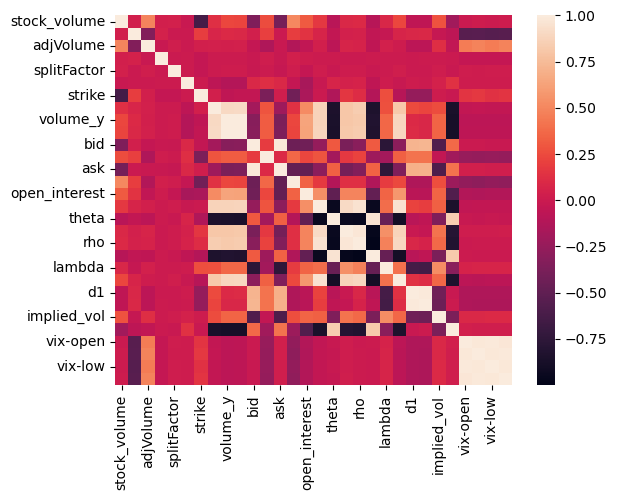

In [86]:
## Seaborn data processing
# df = df.shift()
# sns.heatmap(df.corr('pearson')) ## df_all is data

processed_df = df.copy()
processed_df = processed_df.drop(columns={"high", "low", "stock_close", "open", "adjHigh", "adjLow", "adjOpen"})
processed_df["implied_vol"] = processed_df["implied_vol"].shift(-1)
print(processed_df["implied_vol"])
# strike_of_zero = processed_df["strike"][processed_df["options_close_price"]==0] / 1000
# stock_of_zero = processed_df["adjClose"][processed_df["options_close_price"]==0]
# print(stock_of_zero)
# processed_df["SMA"] = processed_df["stock_close"].rolling(window=30).mean()
# processed_df["SMA"] = processed_df["SMA"].fillna(0)
# typical_price = (processed_df["adjHigh"] + processed_df["adjLow"] + processed_df["adjClose"])/3
# raw_money_flow = typical_price * processed_df["stock_volume"]
sns.heatmap(processed_df.corr(method='spearman'))
# sns.pairplot(df)